<a href="https://colab.research.google.com/github/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/FnB_CPG_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimizing Vending Machine Inventory with AI: A Deep Dive into Model Selection

### Introduction:
Vending machines, once simple dispensers, are evolving into data-driven hubs. To maximize customer satisfaction and revenue, owners need real-time insights into product consumption. This article explores how Vision AI can enhance inventory management by using cameras to monitor purchases.

### The Challenge:
Traditional inventory methods often rely on manual checks or unreliable sensors. Vision AI offers a more accurate and efficient solution. However, the diversity of products in vending machines, coupled with varying package sizes and shapes, presents a unique challenge.

### The Solution: Deep Learning
Deep learning, a subset of AI, is ideally suited for this task. It can learn complex patterns from vast datasets, making it capable of identifying and classifying products even in the face of variations.

### Beyond the model: The Vision AI stack
While the AI model is crucial, it is part of the larger vision AI solution stack. Key components include:
1. Hardware Selection: Choosing the right camera with desired FoV that can capture high quality images in various lighting conditions
2. Hardware Installation: Ensuring cameras are securely mounted and positioned to capture optimal product views without being intrusive or compromising customer experience.
3. Data Transmission: Selecting reliable communication mechanism to transmit image/video data to the processing system
4. Processing System: Determining whether to run the AI model on-device (edge computing) or in the cloud or in a hybrid fashion.
5. Data Storage: Saving necessary data to support future analysis and reporting
6. Data Presentation: Helping owners visualize the insights via a front-end application

### Model Development: A Deep Dive

To accurately track product purchases, we need a reference database containing images and corresponding information for each product in the vending machine, including product name and location within the machine. Our motion-detection camera captures footage whenever a customer makes a purchase. By analyzing the movement of the product from its slot, we can effectively identify the specific item purchased.

Our AI models must perform the following tasks:
1. Object Detection: Identify and locate individual products within a vending machine image by placing bounding boxes around them.
2. Optical Character Recognition (OCR): Extract text from the cropped images within each bounding box to determine the product name. These names will serve as the classes or product types carried by the vending machine.
3. Object Classification (Optional): Given an image of a product, accurately categorize it into one of the predefined classes based on its visual features. Alternatively, we can use the images captured before and after a purchase to identify the slot/bounding box from which the product was taken. This information can then be mapped back to the product name using the reference database.

An AI model development involved the following 6 steps:
1. Data Collection: Gather a diverse dataset of images depicting various products in vending machines. Ensure the dataset covers different lighting conditions, angles, and product placements.
2. Data Preprocessing: Clean and prepare the data for training. This may involve resizing images, normalizing pixel values, and augmenting the dataset to introduce variations.
3. Model Architecture Selection: Choose a suitable deep learning architecture, such as a convolutional neural network (CNN), which excels at image recognition tasks.
4. Training: Train the model on the prepared dataset. This involves feeding the model images and their corresponding labels, allowing it to learn the underlying patterns.
5. Validation: Evaluate the model's performance on a separate validation dataset to assess its generalization ability.
6. Inference: Deploy the trained model to analyze real-time camera feeds and predict the products being purchased.

We will look into each one of these 6 steps in detail for both Object Detection model and the OCR model, starting with Object Detection model first.

## Object Detection Model
In order to determine whether I can use an existing pre-trained AI model as-is for my application or will I have to train or fine-tune a model, I had to evaluate whether any of the pre-trained models will work or not. So, I shortlisted top object detection models:
Many object detectors use 2 stages, first generating object proposals to identify regions of interest in an image using one AI model and then passing these regions to a detection AI model to classify them. One stage methods prioritize inference speed over detection accuracy. Below are top 2 detector models:
1. YOLO (You only look once) - single stage detector
2. Faster R-CNN  - Two-stage detector

Let's quickly evaluate how these pre-trained versions of the above models perform for this application that requires detecting packaged food and beverages.

In [ ]:
!pip install ultralytics

In [32]:
# Use wget to download test images from the URL
!wget https://github.com/mukund-rajukumar/My-VisionAI-Projects/blob/2e4f1ad507b96a7eaaaffa5368ec7b98c69e2cab/FoodAndBevPackageDetection/images/vending2.jpg?raw=true -O vending2.jpg
!wget https://github.com/mukund-rajukumar/My-VisionAI-Projects/blob/2e4f1ad507b96a7eaaaffa5368ec7b98c69e2cab/FoodAndBevPackageDetection/images/vending2.jpg?raw=true -O vending3.jpg

# Get helper function
!wget https://github.com/mukund-rajukumar/My-VisionAI-Projects/blob/417e3b5bba291225a9198f6b4a75b0e9ab2321c6/MyUtils.py


--2024-09-27 12:43:06--  https://github.com/mukund-rajukumar/My-VisionAI-Projects/blob/2e4f1ad507b96a7eaaaffa5368ec7b98c69e2cab/FoodAndBevPackageDetection/images/vending2.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mukund-rajukumar/My-VisionAI-Projects/raw/2e4f1ad507b96a7eaaaffa5368ec7b98c69e2cab/FoodAndBevPackageDetection/images/vending2.jpg [following]
--2024-09-27 12:43:06--  https://github.com/mukund-rajukumar/My-VisionAI-Projects/raw/2e4f1ad507b96a7eaaaffa5368ec7b98c69e2cab/FoodAndBevPackageDetection/images/vending2.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mukund-rajukumar/My-VisionAI-Projects/2e4f1ad507b96a7eaaaffa5368ec7b98c69e2cab/FoodAndBevPackageDetection/images/vending2.jpg [following]
--2024-09-27 12:43:07-

In [33]:
#@title Let's test with a pre-trained version of Yolo (v8). Nano is the smallest variant of v8 with 3.2M parameters
from ultralytics import YOLO
import MyUtils

# Load a pretrained YOLO model
model = YOLO("yolov8n.pt")
MyUtils.count_params(model)

def plot_yolo_results(results):
  # Process results list
  for result in results:
      boxes = result.boxes  # Boxes object for bounding box outputs
      masks = result.masks  # Masks object for segmentation masks outputs
      keypoints = result.keypoints  # Keypoints object for pose outputs
      probs = result.probs  # Probs object for classification outputs
      obb = result.obb  # Oriented boxes object for OBB outputs
      # result.show()  # display to screen
      result.save(filename="result.jpg")  # save to disk
      res_img = Image.open("result.jpg")
      plt.imshow(res_img)
      plt.show()

SyntaxError: invalid decimal literal (MyUtils.py, line 123)


image 1/1 /content/vending2.jpg: 576x640 5 bottles, 1 dining table, 3 books, 69.1ms
Speed: 3.9ms preprocess, 69.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


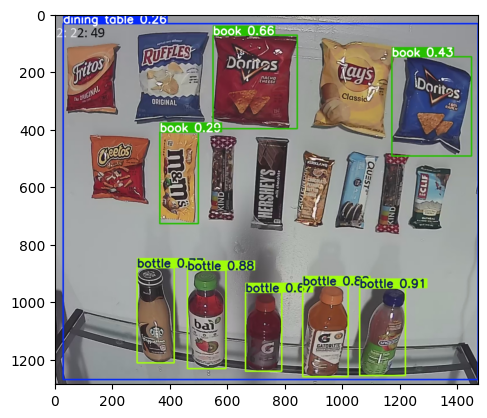

In [ ]:
# Perform object detection on an image
results = model("vending2.jpg")
plot_yolo_results(results)


image 1/1 /content/vending3.jpg: 640x640 12 bottles, 1 refrigerator, 73.1ms
Speed: 2.7ms preprocess, 73.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


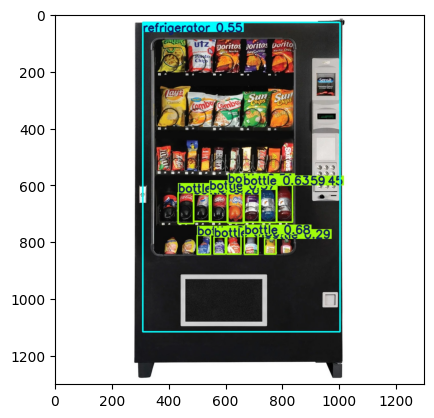

In [ ]:
results = model("vending3.jpg")
plot_yolo_results(results)

### Result Analysis
The Yolo models come pre-trained on [VOC](https://pjreddie.com/projects/pascal-voc-dataset-mirror/#google_vignette) and [COCO](https://cocodataset.org/#home) datasets. These datasets have bottle as one of the image categories but they do not have a category for food packages. So, this model is NOT trained to detect packages.

In [6]:
#@title Now let's test with Faster-RCNN (43M parameters)
# Reference: https://pytorch.org/vision/stable/models.html

from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import cv2

img = read_image("vending2.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)

model.eval()
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]

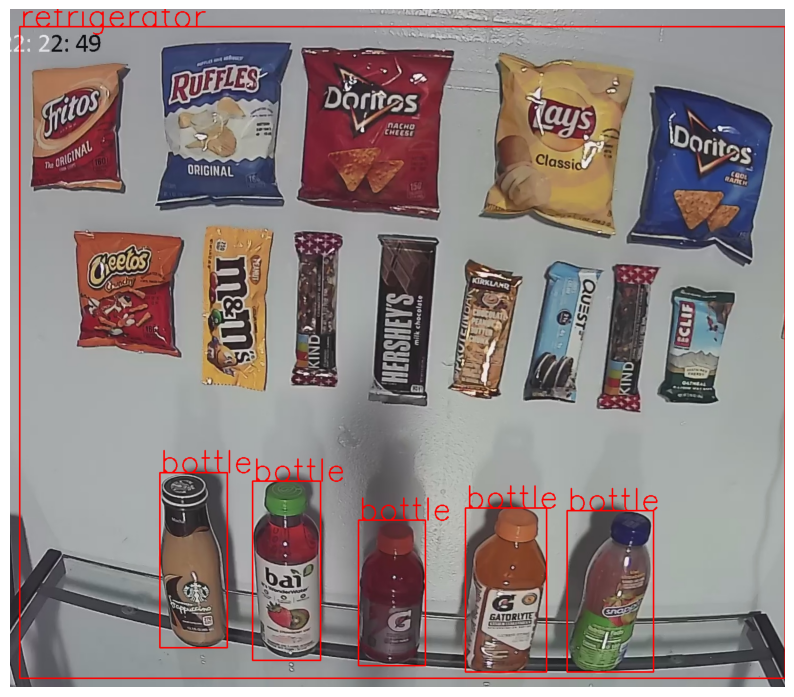

In [ ]:
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

boxes=prediction["boxes"]
labels=labels
colors=(255,0,0)
image = np.array(img.permute(1, 2, 0), dtype=np.uint8)
thickness = 2

for i, (box, label) in enumerate(zip(boxes, labels)):
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color=colors, thickness=thickness)
    cv2.putText(image, str(label), (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=colors, thickness=thickness)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


### Result Analysis
The Faster R-CNN model comes pre-trained on [COCO](https://cocodataset.org/#home) dataset. This dataset has bottle and refrigerator as image categories but not food packages. So, this model is NOT trained to detect packages.